# Introduction

Graph Neural Networks (GNNs) in the last few years have emerged as powerful tools for modeling complex, (semi-) structured, non-Euclidean data distributions. This has made them particularly well-suited for tasks such as molecular property prediction. This project focuses on leveraging a GNN to identify whether specific molecules, represented as graphs, have the potential to combat HIV. By treating molecules as graphs—with atoms as nodes and bonds as edges—the GNN can capture intricate relationships within the molecular structure.

<!-- As a Software Engineer at AWS Config, I have primarily worked on developing  secure cloud systems, but I have also lead the service in application-layer generative AI features. This project represents a deliberate effort to demonstrate my expertise (through my diverse background) in picking up new rapidly evolving fields of machine learning research (& technology). As mentioned in my resume, my research background focused on Agro-AI, Differentiable Audition & Differentiable Economics.   -->

As a Software Engineer at AWS Config, I've honed my skills in building secure cloud systems. In my tenure, I have also been at the forefront of integrating application-layer generative AI features into the service. This project showcases my ability to quickly adapt to emerging technologies and apply my diverse machine learning background, including research in Agro-AI, Differentiable Audition, and Differentiable Economics. In this Colab notebook, I'll delve into the application of graph transformers, demonstrating my proficiency in this rapidly evolving field.

In the following sections of this notebook, I will provide
1. An Overview of the dataset and the preprocessing steps undertaken to prepare the molecular graphs for training.
2. The Architectural details of the GNN model, including choice of layers and hyperparameters
3. Details on the training process designed, along with the evaluation metrics used to assess model performance.
4. Results, an analysis of model predictions, and an outline discussing  future improvements to enhance the accuracy and applicability of the model.
5. A path to productionize the model on AWS

In [1]:
!pip install datasets rdkit-pypi networkx torch-geometric ogb graphviz torchview torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=cf10aba5ec70a0537cfeed029d36b73669561bf1fa42b2e781c776f0b82aed6b
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4

## Hyperparameters

Below are the hyper parameters used for the model. These must be initialized for every other cell to work

In [9]:
epochs = 150
learning_rate = 1e-4
train_batch_size = 128
test_batch_size = 32
valid_batch_size = 128
transformer_depth = 10
transformer_heads = 5
gps_transformer_heads = 1
hidden_dim = 192
compute_eng = 'cuda'
loss_gamma = 1.1
loss_clamp_range = 1e-9

# Dataset

The data set we will be using comes from our good friends at Stanford! You can find additional information about them [here](https://ogb.stanford.edu/)

Researchers use this dataset to figure out if a molecule can fight off HIV by analyzing the way these atoms are bonded (the way the dots are connected via the lines).

The dataset includes:
* **Atoms & Bonds:** The dataset includes information about the types of atoms in each molecule and the bonds connecting them
* **Molecule Size:** Each molecule's size is recorded which defines how many atoms (nodes) are in it
* **Labels:** For each molecule, the dataset provides a "yes" or "no" as to whether the molecule can potentially stop HIV

The ```ogbg-molhiv``` dataset is curated for **molecular property** prediction. Derived from ```MoleculeNet```, the dataset is structured for GNN-based graph-level prediction tasks.

The labelling task for this dataset is ***Binary Classification*** on whether a molecule, represented as a graph, has the ability to inhibit HIV. Performance is measured by the ROC-AUC score.

## Structure

The dataset is split into `train`, `validation`, & `test` sets

Each datapoint (across sets) consists of:
1. `edge_index`: Represents the edges (bonds) between atoms in the molecule.    The first list corresponds to the source nodes (atoms), and the second list corresponds to the destination nodes. These two lists together form the undirected bonds between atoms.

2. `edge_attr`: List of 3-dimensional vectors that describes the bond features between two atoms. These vectors are structured as:

  a. **Bond type**: Index into the bond type list
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
        'misc'
  
  b. **Bond stereochemistry**: Represents the stereochemistry of the bond, such as
        'STEREONONE',
        'STEREOZ',
        'STEREOE'
  
  c. **Is conjugated**: Whether the bond is conjugated (alternating single/double bonds). Binary value.
3. `node_feat`: a 9-dimensional vector representing the features of an atom. The features are (in index order):
  
  a. `Atomic number`: Carbon = 6, Hydrogen = 1, etc.
  Possible Values: `RANGE(1, 118)`
  
  b. `Chirality`: Represents how the atom in the current molecular structure can be superimposed into the molecule's mirror image across different planes. Possible Values:
  ```python
    'CHI_UNSPECIFIED',
    'CHI_TETRAHEDRAL_CW',
    'CHI_TETRAHEDRAL_CCW',
    'CHI_OTHER',
    'misc'
  ```
  
  c. `Degree`: the number of atoms this atom is connected to.
  Possible Values: `RANGE(0,10)`

  d. `Formal Charge`: derived from bias of the shared valence electrons in the molecule's neighborhood.
  Possible Values: `RANGE(-5,5)`
  
  e. `Number of Hydrogen Atoms`: number of attached hydrogen atoms.
  Possible Values: `RANGE(0,10)`
  
  f. `Number of Radical Electrons`: number of electrons in atom not paired with another atom's electrons.
  Possible values: `RANGE(0,4)`

  g. `Hybridization`: number representing index of a hybridization state,
  Possible Values:
  ```python
      'SP',
      'SP2',
      'SP3',
      'SP3D',
      'SP3D2',
      'misc'
  ```
  h. `IsAromatic`: **binary value** classifying atom as aromatic or not
  
  i. `IsRing`: **binary value** classifying atom as a part of a ring molecular structure
4. `num_nodes`: # of nodes/atoms in the datapoint/molecule
5. `y`/`LABEL`: **binary** value representing whether molecule will successfully inhibit HIV



In [ ]:
from datasets import load_dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

ds = load_dataset("OGB/ogbg-molhiv")
# ogbg_molhiv_pg_list = [Data(graph) for graph in ds["train"]]
# ogbg_molhiv_pg = DataLoader(ogbg_molhiv_pg_list)
print(ds)
print(ds['train'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/59.1M [00:00<?, ?B/s]

valid.jsonl:   0%|          | 0.00/8.23M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/7.50M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/32901 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4113 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 32901
    })
    validation: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 4113
    })
    test: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 4113
    })
})
{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 10, 12, 12, 13, 13, 14, 14, 15, 14, 16, 14, 17, 4, 18, 18, 19, 19, 20, 19, 21, 19, 22, 18, 23, 23, 1, 13, 7], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 10, 13, 12, 14, 13, 15, 14, 16, 14, 17, 14, 18, 4, 19, 18, 20, 19, 21, 19, 22, 19, 23, 18, 1, 23, 7, 13]], 'edge_attr': [[0, 0, 1], [0, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [0, 0, 1], [0, 0, 1], [1, 0, 1], [1, 0, 1], [0, 0, 1], [0, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3

## Visualization

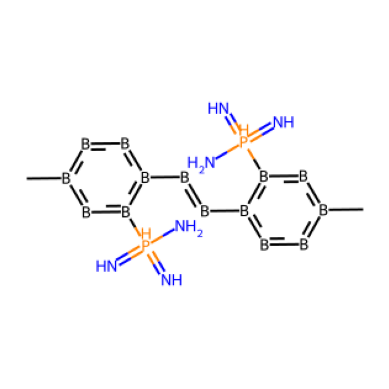

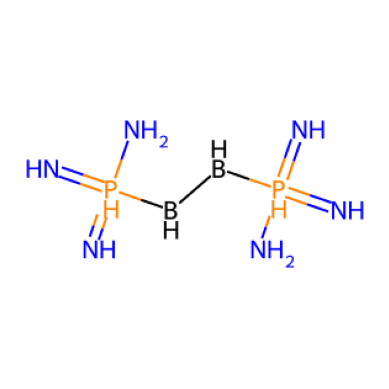

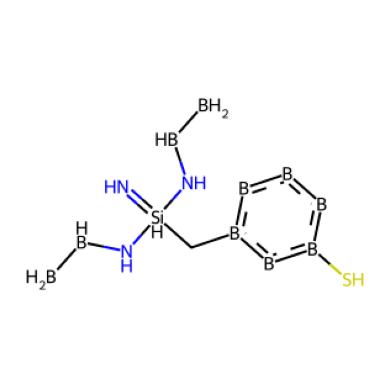

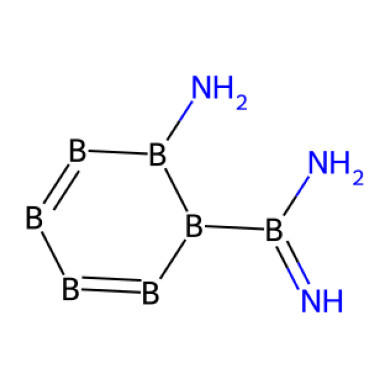

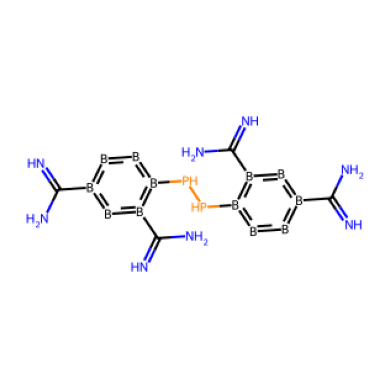

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch
import networkx as nx

bond_types = [
    Chem.BondType.SINGLE,
    Chem.BondType.DOUBLE,
    Chem.BondType.TRIPLE,
    Chem.BondType.AROMATIC,
    Chem.BondType.UNSPECIFIED
]
# Function to convert a PyG molecule graph to SMILES for RDKit visualization
def visualize_molecule(data):
  # Extract node features (atom information) and edge index (bond connections)
  edge_index = torch.tensor(data['edge_index'])
  num_nodes = data['num_nodes']
  atom_features = data['node_feat']
  mol = Chem.RWMol()

  # Add atoms
  for i in range(num_nodes):
    # print(atom_features[i])
    mol.AddAtom(Chem.Atom(atom_features[i][0]))

  # Add bonds
  bond_store_rep = []
  for i in range(len(edge_index[0])):
    start, end = edge_index[0, i], edge_index[1, i]
    edge_type = data['edge_attr'][i][0]
    if (start, end) not in bond_store_rep:
      mol.AddBond(int(start), int(end), bond_types[int(edge_type)])
      bond_store_rep.append((start, end))
      bond_store_rep.append((end, start))
  return mol

# Visualize the first 5 molecules
for i in range(5):
  data = ds['train'][i]
  mol = visualize_molecule(data)
  img = Draw.MolToImage(mol)

  plt.imshow(img)
  plt.axis('off')
  plt.show()

## Dataloaders

In [20]:
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader

dataset = PygGraphPropPredDataset(name = "ogbg-molhiv")

split_idx = dataset.get_idx_split()
train_loader = DataLoader(dataset[split_idx["train"]],
                          batch_size=train_batch_size, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]],
                          batch_size=valid_batch_size, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]],
                         batch_size=test_batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed

In [4]:
print(split_idx)

{'train': tensor([    3,     4,     5,  ..., 41124, 41125, 41126]), 'valid': tensor([10127, 10129, 10132,  ..., 22785, 22786, 22788]), 'test': tensor([    0,     1,     2,  ..., 10122, 10124, 10125])}


# Training Set Up

## Model Engineering

For this project we are implementing a graph transformer based model.

<ins>Architectural Details</ins>
1. Initial layer uses a

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv, GPSConv, global_mean_pool, GINEConv

'''
Consider adding MessagePassing layer
'''
class HivDetectorModel(nn.Module):
  def __init__(self, input_dim, edge_dim, hidden_dim, output_dim,
               num_layer_transformer=3, num_heads_transformer=3, num_heads_gps=3):

    super(HivDetectorModel, self).__init__()

    # projecting data via linear layer to avoid dimensionality issues
    self.init_linear = nn.Linear(input_dim, hidden_dim)

    self.local_conv = GINEConv(
      nn=nn.Sequential(
          nn.Linear(hidden_dim, hidden_dim),
          nn.GELU(),
          nn.Linear(hidden_dim, hidden_dim)
      ),
      edge_dim=edge_dim
    )

    # Initial layer for capturing global relationships early
    self.gps_layer = GPSConv(
        channels=hidden_dim,
        conv=self.local_conv,
        heads=num_heads_gps,
        act='gelu',
        attn_type='multihead',
        # attn_kwargs={
        #     'edge_dim': edge_dim,
        #     'share_weights': True
        # }
    )

    # Graph Transformer layers (accepting edge attributes)
    self.transformer_layers = nn.ModuleList()
    for i in range(num_layer_transformer):
      # No dropout probability or message passing layer
      self.transformer_layers.append(
          TransformerConv(hidden_dim, hidden_dim,
                          heads=num_heads_transformer, edge_dim=edge_dim, concat=False))

    # MLP for output prediction
    self.mlp = nn.Sequential(
      nn.Linear(hidden_dim, hidden_dim),
      nn.GELU(),
      nn.Linear(hidden_dim, output_dim),
      nn.Sigmoid()
    )

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    edge_attr, batch = data.edge_attr, data.batch

    # Dimensionality increase to hidden dimension value
    x = self.init_linear(x)
    x = F.gelu(x)

    # Add GPSConv layer when ready
    x = self.gps_layer(x, edge_index, batch=batch, edge_attr=edge_attr)

    # Successive passes through the transformer layers
    for conv in self.transformer_layers:
      x = conv(x, edge_index, edge_attr)
      x = F.gelu(x)

    # Global pooling
    x = global_mean_pool(x, batch)

    # Final MLP layer
    x = self.mlp(x)
    return x

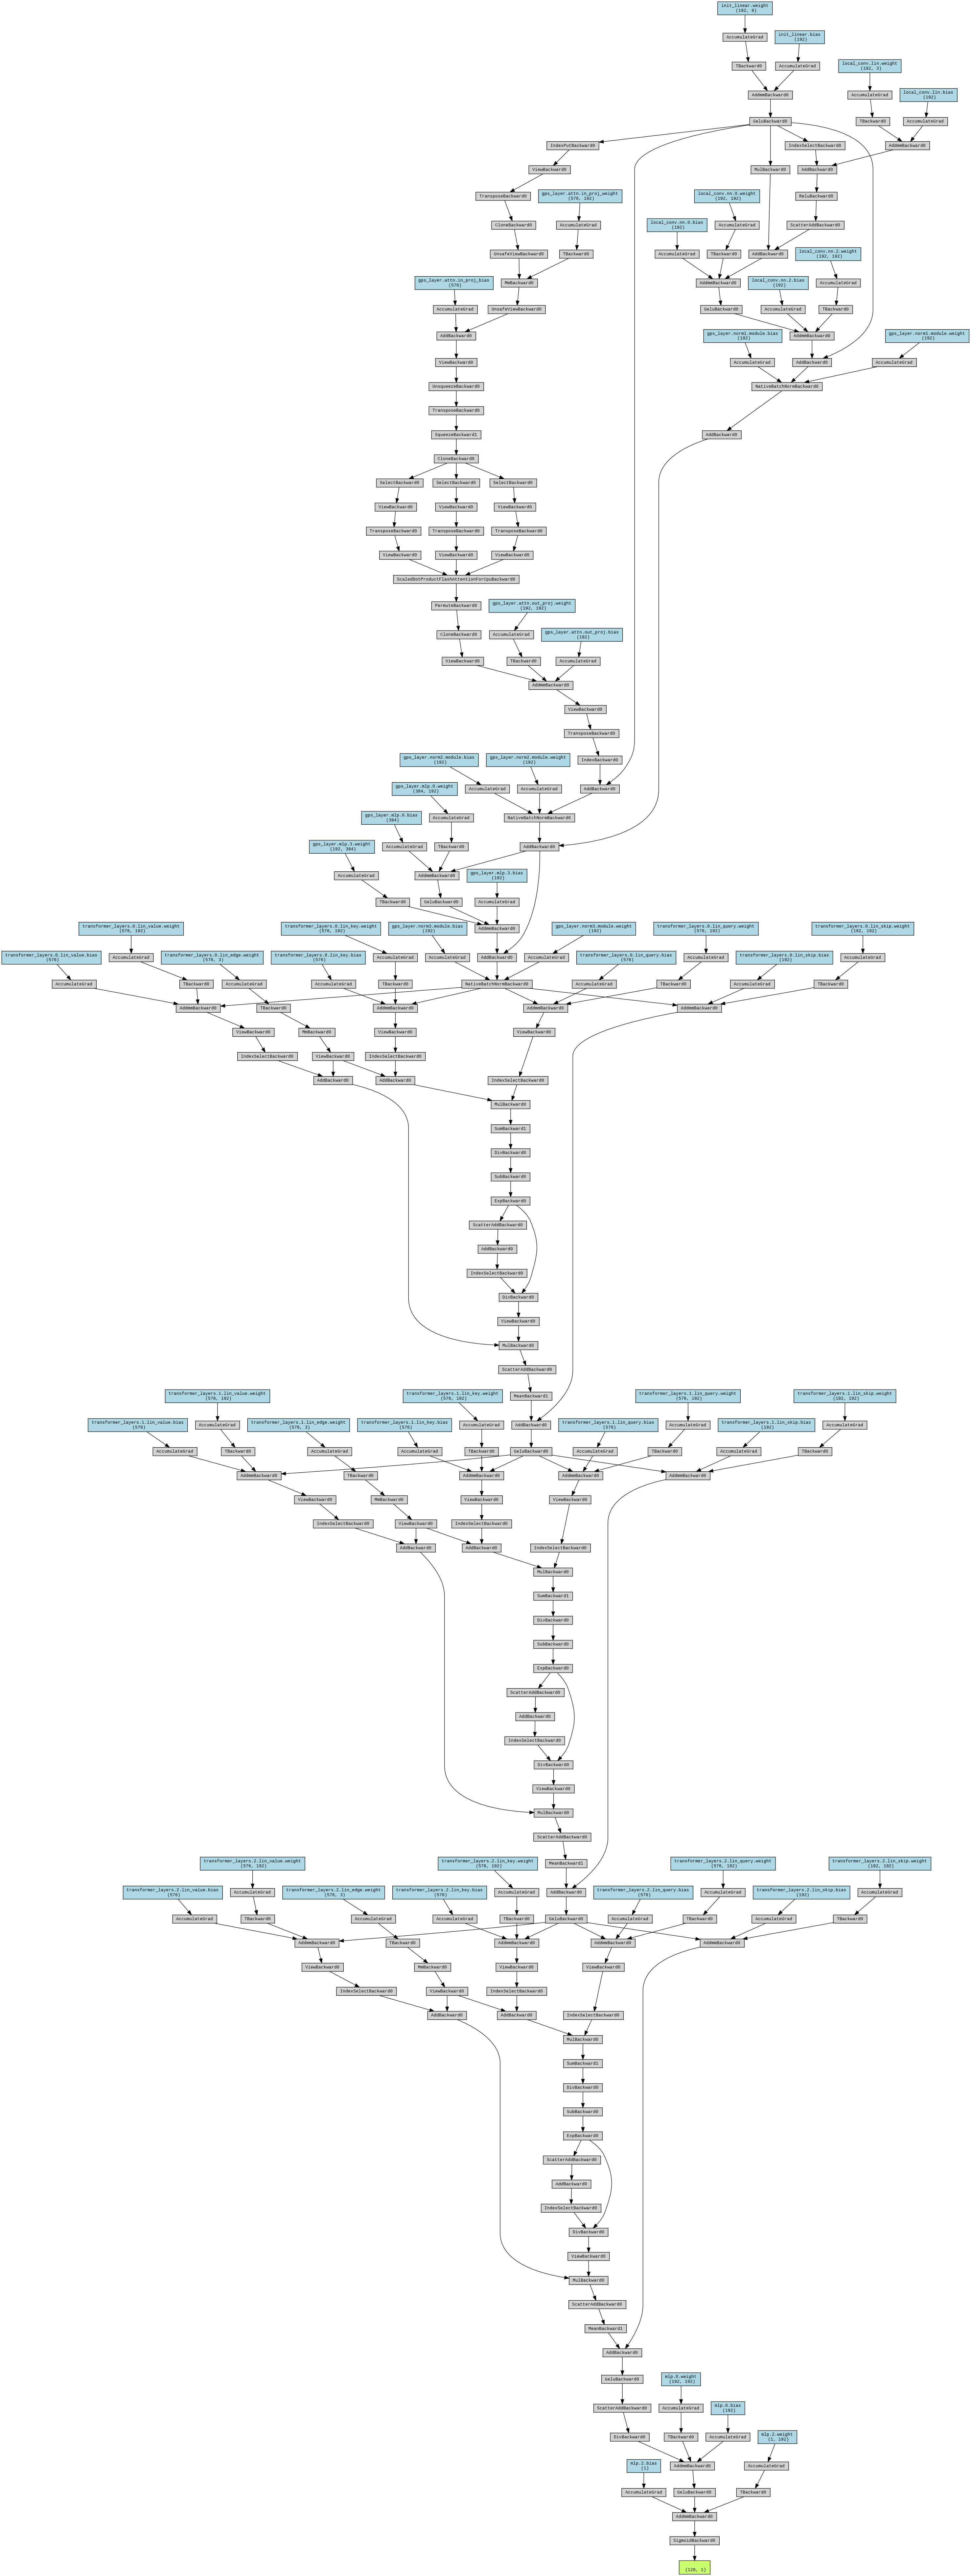

In [6]:
from torchviz import make_dot
from torch_geometric.data import Data
from IPython.display import Image

model = HivDetectorModel(input_dim=9, edge_dim=3, hidden_dim=192, output_dim=1)
out = None
for data in train_loader:
  data.x = data.x.type(torch.FloatTensor)
  # data.edge_index = data.edge_index
  data.edge_attr = data.edge_attr.type(torch.FloatTensor)
  out = model(data)
  break
dot = make_dot(out, params=dict(model.named_parameters()))
dot.render('model_visualization', format='png')
Image('model_visualization.png')

## Objective/Loss Function Engineering

For this task we will be using a binary cross entropy with logits (BCE) loss. More details about the loss function can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#bcewithlogitsloss)

### LOSS TRIAL V1

In [ ]:
# Calculating data imbalance first to
# parametrize the pos_weight arg in loss function
pos_ct, tot_ct = 0, 0
for batch_data in train_loader:
  tot_ct += batch_data.y.shape[0]
  pos_ct += batch_data.y.sum().item()
pos_split = pos_ct/tot_ct
print(pos_split)
print(pos_ct)
print(tot_ct)

0.03744567034436643
1232
32901


In [ ]:
from torch.nn import BCEWithLogitsLoss
# Calculating positive label weight based on split above
pos_weight = (1 - pos_split)/pos_split
print('Using Weight: {} for positive labels given imbalance'.format(pos_weight))
criterion = BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=compute_eng))

Using Weight: 25.705357142857146 for positive labels given imbalance


### LOSS TRIAL V2

In [7]:
'''
Trying Focal Loss to see if that improves training
'''

import torch.nn.functional as F
import torch

class FocalLoss(nn.Module):
  def __init__(self, alpha=0.25, gamma=2, clamp_range=1e-6, reduction='mean'):
    super(FocalLoss, self).__init__()
    self.alpha = alpha  # Weight for the positive class
    self.gamma = gamma  # Focusing parameter
    self.red = reduction
    self.clamp = clamp_range

  def forward(self, inputs, targets):
    # Compute BCE with logits loss
    # BCE_loss = F.binary_cross_entropy(inputs.view(-1), targets.view(-1))
    # pt = torch.exp(-BCE_loss)  # Probabilities
    # # Compute focal loss
    # F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
    # return F_loss.mean()
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    # Clamping values to prevent log(0)
    inputs = torch.clamp(inputs, min=self.clamp, max=1-self.clamp)

    # Calculating loss
    bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')

    # Compute modulating factor
    # pt = p if y == 1 else 1 - p
    pt = targets * inputs + (1 - targets) * (1 - inputs)
    modulating_factor = (1 - pt) ** self.gamma

    # Compute the alpha factor
    alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)

    # Compute the final loss
    focal_loss = alpha_factor * modulating_factor * bce_loss

    match self.red:
      case "mean":
        return focal_loss.mean()
      case "sum":
        return focal_loss.sum()
      case _:
        return focal_loss



def calculate_alpha(data_loader):
  pos_ct, tot_ct = 0, 0
  for batch_data in data_loader:
    tot_ct += batch_data.y.shape[0]
    pos_ct += batch_data.y.sum().item()
  pos_split = pos_ct/tot_ct
  return 1 - pos_split

In [8]:
criterion = FocalLoss(alpha=calculate_alpha(train_loader), gamma=loss_gamma,
                      clamp_range=loss_clamp_range, reduction='sum')

## Setting up Training Function

In [10]:
import torch
import torch.nn as nn
def train_model(dataloader, optimizer, criterion, device):
  # model.train()
  total_loss = 0
  pos_correct = 0
  pos_total = 0
  tot_correct = 0
  tot_samples = 0
  for batch in dataloader:
    # Adding Batch to GPU
    batch.x = batch.x.float().to(device)
    batch.edge_index = batch.edge_index.long().to(device)
    batch.edge_attr = batch.edge_attr.float().to(device)
    batch.y = batch.y.float().to(device)
    batch.batch = batch.batch.long().to(device)
    # Forward & Backward pass
    optimizer.zero_grad()
    out = model(batch).to(device)
    loss = criterion(out, batch.y.float())
    loss.backward()
    # ---Gradient debugging---
    # for name, param in model.named_parameters():
    #   # print(f'{name} requires_grad: {param.requires_grad}')
    #   if param.grad is not None:
    #     print(f'Gradient for {name}: {param.grad.norm()}')
    #   else:
    #     print(f'No gradient computed for {name}')
    optimizer.step()
    total_loss += loss.item()

    # Calculating Training accuracy
    pred = (out > 0.5).float()
    pos_correct += ((pred.view(-1) == batch.y.view(-1)) &
                    (batch.y.view(-1) == 1)).sum().item()
    pos_total += (batch.y.view(-1) == 1).sum().item()

    tot_correct += (pred.view(-1) == batch.y.view(-1)).sum().item()
    tot_samples += batch.y.shape[0]

  return total_loss/tot_samples, pos_correct/pos_total, tot_correct/tot_samples

## Setting up Validation Function

In [11]:
def validate_model(dataloader, criterion, device):
  # model.eval()
  total_loss = 0
  pos_correct = 0
  pos_total = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch in dataloader:
      # Add batch to GPU
      batch.x = batch.x.float().to(device)
      batch.edge_index = batch.edge_index.long().to(device)
      batch.edge_attr = batch.edge_attr.float().to(device)
      batch.y = batch.y.float().to(device)
      batch.batch = batch.batch.long().to(device)

      # Fwd inference
      out = model(batch)
      loss = criterion(out, batch.y.float())
      total_loss += loss.item()

      # Model accuracy
      pred = (out > 0.5).float()  # Threshold at 0.5 for binary classification
      correct += (pred.view(-1) == batch.y.view(-1)).sum().item()
      pos_correct += ((pred.view(-1) == batch.y.view(-1)) &
                    (batch.y.view(-1) == 1)).sum().item()
      pos_total += (batch.y.view(-1) == 1).sum().item()
      total += batch.y.shape[0]
  return total_loss/len(dataloader), correct/total, pos_correct/pos_total

# Training Loop

In [12]:
'''
initializing model, optimizer, and device
'''
from torch.optim import Adam
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cuda'
model = HivDetectorModel(input_dim=9, edge_dim=3, hidden_dim=hidden_dim,
                         output_dim=1, num_layer_transformer=transformer_depth,
                         num_heads_transformer=transformer_heads,
                         num_heads_gps=gps_transformer_heads).to(compute_eng)
optimizer = Adam(model.parameters(), lr=learning_rate)

In [13]:
print(next(model.parameters()).is_cuda)
print(next(model.parameters()).device)
# print(device)
device = 0

True
cuda:0


In [14]:
'''
We are setting up the training loop here
Additionally setting up plot logic
'''
train_losses = []
train_pos_accs = []
train_tot_accs = []
val_losses = []
val_accs = []
val_pos_accs = []
for epoch in range(epochs):
  # Model Training
  model.train()
  avg_train_loss, pos_correct, tot_correct = train_model(train_loader, optimizer,
                                                         criterion, compute_eng)
  train_pos_accs.append(pos_correct)
  train_tot_accs.append(tot_correct)
  train_losses.append(avg_train_loss)

  # Model Evaluation
  model.eval()
  val_loss, val_acc, val_pos_acc = validate_model(valid_loader, criterion,
                                                  compute_eng)
  val_losses.append(val_loss)
  val_accs.append(val_acc)
  val_pos_accs.append(val_pos_acc)
  if epoch % 5 == 0:
    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Train Positive Accuracy: {pos_correct:.4f}, Train Total Accuracy: {tot_correct:.4f}")
    print(f"Epoch {epoch}, Val Loss: {val_loss:.4f}, Val Positive Accuracy: {val_pos_acc:.4f}, Val Total Accuracy: {val_acc:.4f}")

Epoch 0, Train Loss: 0.0227, Train Positive Accuracy: 0.6802, Train Total Accuracy: 0.4748
Epoch 0, Val Loss: 2.0578, Val Positive Accuracy: 0.3457, Val Total Accuracy: 0.7437
Epoch 5, Train Loss: 0.0198, Train Positive Accuracy: 0.6153, Train Total Accuracy: 0.7752
Epoch 5, Val Loss: 1.8487, Val Positive Accuracy: 0.5926, Val Total Accuracy: 0.8220
Epoch 10, Train Loss: 0.0184, Train Positive Accuracy: 0.6185, Train Total Accuracy: 0.8354
Epoch 10, Val Loss: 1.7578, Val Positive Accuracy: 0.5679, Val Total Accuracy: 0.8434
Epoch 15, Train Loss: 0.0174, Train Positive Accuracy: 0.6388, Train Total Accuracy: 0.8695
Epoch 15, Val Loss: 1.7892, Val Positive Accuracy: 0.5679, Val Total Accuracy: 0.8407
Epoch 20, Train Loss: 0.0163, Train Positive Accuracy: 0.6542, Train Total Accuracy: 0.8768
Epoch 20, Val Loss: 1.6515, Val Positive Accuracy: 0.5432, Val Total Accuracy: 0.9027
Epoch 25, Train Loss: 0.0153, Train Positive Accuracy: 0.6948, Train Total Accuracy: 0.8762
Epoch 25, Val Loss: 1.

# Results

## Loss Analysis

Plotting training & validation losses

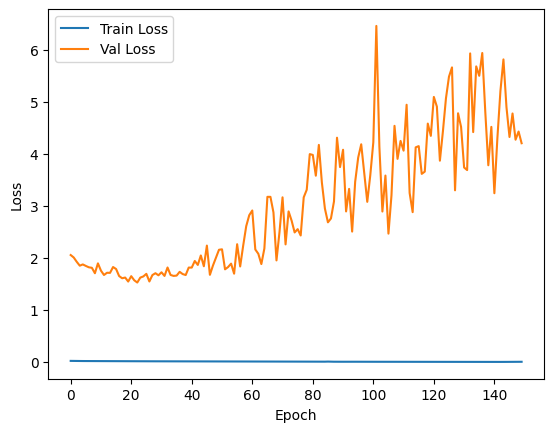

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The ideal place to stop training would have been around **epoch = 25** given the current model structure. It is suspicious however that the validation loss is consistently ***higher*** than the training loss, implying that we are consistently ***overfitting***. This is most likely due to the introduction of the **GPSConv** layer to the model. The higher complexity (from additional parametrization of the model via attn based aggregation) is likely the root cause of the overfitting.

## Label Accuracy Analysis

Plotting Positive Label accuracy for both training & validation, and plotting total accuracy for training & validation.

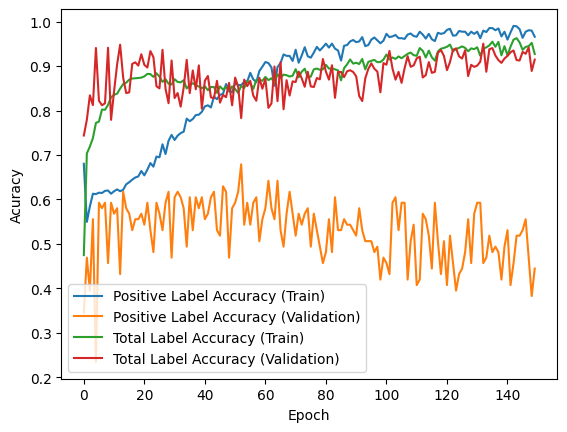

In [18]:
plt.plot(train_pos_accs, label='Positive Label Accuracy (Train)')
plt.plot(val_pos_accs, label='Positive Label Accuracy (Validation)')
plt.plot(train_tot_accs, label='Total Label Accuracy (Train)')
plt.plot(val_accs, label="Total Label Accuracy (Validation)")
plt.xlabel("Epoch")
plt.ylabel("Acuracy")
plt.legend()
plt.show()

The training accuracy is consistently increasing for positive label prediction (when a molecule can inhibit HIV) while validation accuracy spiked, and then levelled off as the model did not become more accurate for label prediction.

This adds up with the earlier analysis that the model is ***consistently overfitting*** as the training accuracies increase over time, while validation accuracies flat line almost immediately after the first 10 epochs.

## Follow Up

For follow up iterations, it would be prudent to **remove** the **GPSConv** layer since its attn based message passing is causing the model to overfit almost immeditately. Additionally, it would be prudent to reduce the number of heads and the depth of the model to reduce parameter count and overall model complexity.

## Test Set

In [23]:
test_acc = 0
tot_samples = 0
test_pos_acc = 0
test_pos_total = 0
model.eval()
with torch.no_grad():
  for batch in test_loader:
    # Add batch to GPU
    batch.x = batch.x.float().to(device)
    batch.edge_index = batch.edge_index.long().to(device)
    batch.edge_attr = batch.edge_attr.float().to(device)
    batch.y = batch.y.float().to(device)
    batch.batch = batch.batch.long().to(device)

    # Fwd inference
    out = model(batch)
    # Model accuracy
    pred = (out > 0.5).float()  # Threshold at 0.5 for binary classification
    test_acc += (pred.view(-1) == batch.y.view(-1)).sum().item()
    tot_samples += batch.y.shape[0]
    test_pos_acc += ((pred.view(-1) == batch.y.view(-1)) &
                    (batch.y.view(-1) == 1)).sum().item()
    test_pos_total += (batch.y.view(-1) == 1).sum().item()

print(f"Model's test accuracy is {test_acc/tot_samples} with a positive label accuracy of {test_pos_acc/test_pos_total}")

Model's test accuracy is 0.9029905178701677 with a positive label accuracy of 0.3230769230769231


### ROC & Precision-Recall Curves

Test ROC AUC: 0.6824


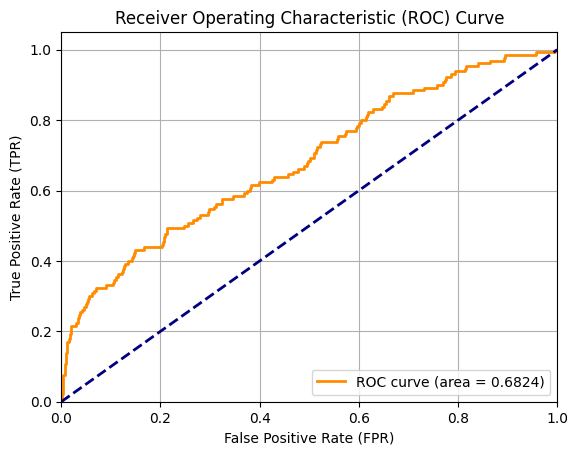

Test Average Precision: 0.1166


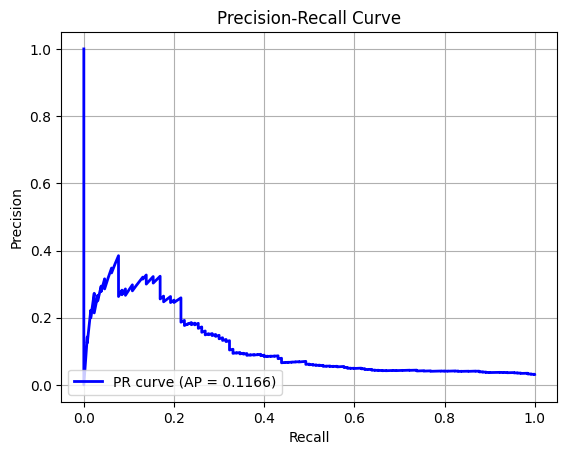

In [26]:
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)
import numpy as np

def compute_roc_auc(model, dataloader, device):
  model.eval()
  all_probs = []
  all_targets = []
  with torch.no_grad():
    for batch in dataloader:
      # batch = batch.to(device)
      batch.x = batch.x.float().to(device)
      batch.edge_index = batch.edge_index.long().to(device)
      batch.edge_attr = batch.edge_attr.float().to(device)
      batch.y = batch.y.float().to(device)
      batch.batch = batch.batch.long().to(device)
      outputs = model(batch)

      # Adjust based on your model's output
      probs = outputs.view(-1).cpu()
      # probs = torch.sigmoid(outputs.view(-1)).cpu()  # Uncomment if needed

      targets = batch.y.view(-1).cpu()
      all_probs.extend(probs.numpy())
      all_targets.extend(targets.numpy())

  all_probs = np.array(all_probs)
  all_targets = np.array(all_targets)
  fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
  roc_auc = auc(fpr, tpr)
  return fpr, tpr, roc_auc

def plot_roc_curve(fpr, tpr, roc_auc):
  plt.figure()
  plt.plot(
      fpr,
      tpr,
      color='darkorange',
      lw=2,
      label='ROC curve (area = %0.4f)' % roc_auc,
  )
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

def compute_precision_recall(model, dataloader, device):
  model.eval()
  all_probs = []
  all_targets = []
  with torch.no_grad():
    for batch in dataloader:
      # batch = batch.to(device)
      batch.x = batch.x.float().to(device)
      batch.edge_index = batch.edge_index.long().to(device)
      batch.edge_attr = batch.edge_attr.float().to(device)
      batch.y = batch.y.float().to(device)
      batch.batch = batch.batch.long().to(device)
      outputs = model(batch)

      # Adjust based on your model's output
      probs = outputs.view(-1).cpu()
      # probs = torch.sigmoid(outputs.view(-1)).cpu()  # Uncomment if needed

      targets = batch.y.view(-1).cpu()
      all_probs.extend(probs.numpy())
      all_targets.extend(targets.numpy())

  all_probs = np.array(all_probs)
  all_targets = np.array(all_targets)
  precision, recall, thresholds = precision_recall_curve(all_targets, all_probs)
  average_precision = average_precision_score(all_targets, all_probs)
  return precision, recall, average_precision

def plot_precision_recall_curve(precision, recall, average_precision):
  plt.figure()
  plt.plot(
    recall,
    precision,
    color='blue',
    lw=2,
    label='PR curve (AP = %0.4f)' % average_precision,
  )
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend(loc='lower left')
  plt.grid(True)
  plt.show()

# Assuming 'model', 'test_loader', and 'compute_eng' are defined

# Compute and plot ROC curve
fpr, tpr, roc_auc = compute_roc_auc(model, test_loader, compute_eng)
print('Test ROC AUC: {:.4f}'.format(roc_auc))
plot_roc_curve(fpr, tpr, roc_auc)

# Compute and plot Precision-Recall curve
precision, recall, average_precision = compute_precision_recall(model, test_loader, compute_eng)
print('Test Average Precision: {:.4f}'.format(average_precision))
plot_precision_recall_curve(precision, recall, average_precision)

The ROC curve looks somewhat ok, and signifies that the model's architecture needs more iteration since the Area Under Curve (AUC) is 0.6824 while an ideal AUC would be 0.8-0.9.

The precision-recall curve looks pretty bad, which is to be expected given that the model over-fitted the data almost instantly. The AUC is 0.1166 which is not ideal, and the curve signifies that the precision, small at the beginning, degrades rapidly as we increase recall.

# Path to Production

After we iterate on this model, the path to production once the model is at a satisfactory learning level will involve the following:

1. Saving model weights
2. Spinning up the requisite container to host the model
3. Deploying the container into ECS/EKS/SageMaker (depending on the traffic frequency)
4. Wiring up the information infrastructure to:
  
  a. Get molecular data into a Graph structure & compute any additional metadata
  
  b. Infer on the data to get the molecular property prediction

  c. Store any meta data that might be required for debugging (including emitted metrics and logs)

  d. Send result back to invoker


## System Diagram

Attached to this repo is an example system design for traffic flows that are inconsistent (have idle periods in between requests), with tolerance for cold start latency.